In [1]:
# (for Google Colab)
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=4304da129bd43ddd5e68e3819b1873805809e089a73aeeda09fd21ec4a8def7e
  Stored in directory: /root/.cache/pip/wheels/96/b9/5d/1138ea8c8f212bce6e97ae58847b7cc323145b3277f2129e2b
Successfully built pyDOE


In [2]:
import os, time, pickle
import jax, flax, optax
import jax.numpy as np
import numpy as onp
from functools import partial
from pyDOE import lhs
from typing import Sequence, Callable
import json
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Must set CUDA_VISIBLE_DEVICES before importing JAX or any other library that initializes GPUs.
# Otherwise, the environment variable change might be ignored.
# "0, 1": first two GPUs / "": no GPU (CPU instead)

# Run on the first GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from jax.extend.backend import get_backend
print(get_backend().platform)

gpu


# Global Variables

In [4]:
side_length = 40.

# Hyperparameters

In [12]:
architecture_list = [[60, 60, 60, 60, 60, 2]] # NN architecture list
# architecture_list = [[20, 2], [60, 2], [20, 20, 2], [60, 60, 2],
#                      [20, 20, 20, 2], [60, 60, 60, 2],
#                      [20, 20, 20, 20, 2], [60, 60, 60, 60, 2],
#                      [20, 20, 20, 20, 20, 2], [60, 60, 60, 60, 60, 2],
#                      [120, 120, 120, 120, 120, 2]] # NN architecture list
lr = 1e-3 # learning rate
num_epochs = 200000 # number of training epochs

# NN Architecture

In [6]:
# Define NN architecture
class PDESolution(flax.linen.Module): # inherit from Module class
    # One behavior of "flax.linen.Module" is to assign the provided argument to the "self.features"
    features: Sequence[int] # dataclass (e.g. [10, 20, 2])

    @flax.linen.compact # a decorator to define the model in more concise and readable way
    def __call__(self, x): # __call__: makes an object callable, which enables you to use instances of the class like functions
        for feature in self.features[:-1]:
            x = flax.linen.tanh(flax.linen.Dense(feature)(x))
        # Final Dense layer
        x = flax.linen.Dense(self.features[-1])(x)
        return x

# Loss Function

In [7]:
# PDE residual
@partial(jax.vmap, in_axes = (None, 0, 0), out_axes = 0)
@partial(jax.jit, static_argnums = (0,)) # decorator closest to the function is applied first
def residual(u, x, y):
    def stress(x, y): # tensor
        dim = 2
        E = 2.35e3
        nu = 0.33
        mu = E / (2. * (1 + nu))
        lmbda = E * nu / ((1 + nu) * (1 - 2*nu))
        def u_vec(coords): # make (n, 2)
            return u(coords[0], coords[1])
        u_jac = jax.jacrev(u_vec) # (2, 2) Jacobian matrix
        u_jac_val = u_jac((np.array([x, y])))
        epsilon = 0.5 * (u_jac_val + u_jac_val.T) # (2, 2)
        # Stress-Strain relationship
        sigma = lmbda * np.trace(epsilon) * np.eye(dim) + 2 * mu * epsilon
        return sigma

    # σ = [[σ11, σ12], [σ21, σ22]]
    jacobian_wrt_x = jax.jacobian(stress, argnums=0)(x, y) # [[∂σ11/∂x, ∂σ12/∂x], [∂σ21/∂x, ∂σ22/∂x]]
    jacobian_wrt_y = jax.jacobian(stress, argnums=1)(x, y) # [[∂σ11/∂y, ∂σ12/∂y], [∂σ21/∂y, ∂σ22/∂y]]
    dsigma11_dx = jacobian_wrt_x[0, 0] # ∂σ11 / ∂x
    dsigma12_dy = jacobian_wrt_y[0, 1] # ∂σ12 / ∂y
    dsigma21_dx = jacobian_wrt_x[1, 0] # ∂σ21 / ∂x
    dsigma22_dy = jacobian_wrt_y[1, 1] # ∂σ22 / ∂y
    lhs1 = dsigma11_dx + dsigma12_dy
    rhs1 = 0.
    lhs2 = dsigma21_dx + dsigma22_dy
    rhs2 = 0.
    return lhs1 - rhs1, lhs2 - rhs2

# Neumann residual
@partial(jax.vmap, in_axes=(None, 0, 0), out_axes=0)
@partial(jax.jit, static_argnums = (0,)) # decorator closest to the function is applied first
def traction(u, x, y):
    x_cen, y_cen, a, b, gamma = np.array([25., 30., 5.0, 2.0, float(onp.pi/3)])
    # Stress tensor
    def stress(x, y):
        dim = 2
        E = 2.35e3
        nu = 0.33
        mu = E / (2. * (1 + nu))
        lmbda = E * nu / ((1 + nu) * (1 - 2*nu))
        def u_vec(coords): # make (n, 2)
            return u(coords[0], coords[1])
        u_jac = jax.jacrev(u_vec) # (2, 2) Jacobian matrix
        u_jac_val = u_jac((np.array([x, y])))
        epsilon = 0.5 * (u_jac_val + u_jac_val.T) # (2, 2)
        # Stress-Strain relationship
        sigma = lmbda * np.trace(epsilon) * np.eye(dim) + 2 * mu * epsilon
        return sigma

    # line at y = 0 or y = side_length
    def line_implicit1(x, y):
        lhs = y
        rhs = 0.
        return lhs - rhs

    def line_implicit2(x, y):
        lhs = y
        rhs = side_length
        return lhs - rhs

     # Normal vector
    def ellipse_implicit(x, y, x_cen, y_cen, a, b, gamma):
        lhs = (((x - x_cen) * np.cos(gamma) + (y - y_cen) * np.sin(gamma))**2 / a**2) +\
              (((x - x_cen) * np.sin(gamma) - (y - y_cen) * np.cos(gamma))**2 / b**2)
        rhs = 1.
        return lhs - rhs

    line_grad1 = jax.grad(line_implicit1, argnums=(0, 1))(x, y) # (n, 2)
    line_normal1 = np.array(line_grad1) # (-) sign for the normals to point
    line_unit_normal1 = line_normal1 / np.linalg.norm(line_normal1)

    line_grad2 = jax.grad(line_implicit2, argnums=(0, 1))(x, y) # (n, 2)
    line_normal2 = np.array(line_grad2) # (-) sign for the normals to point
    line_unit_normal2 = line_normal2 / np.linalg.norm(line_normal2)

    ellipse_grad = jax.grad(ellipse_implicit, argnums=(0, 1))(x, y, x_cen, y_cen, a, b, gamma) # (n, 2)
    ellipse_normal = -np.array(ellipse_grad) # (-) sign for the normals to point inward
    ellipse_unit_normal = ellipse_normal / np.linalg.norm(ellipse_normal)

    # Traction
    traction1 = np.dot(stress(x, y), line_unit_normal1) # (n, 2)
    traction2 = np.dot(stress(x, y), line_unit_normal2)
    traction3 = np.dot(stress(x, y), ellipse_unit_normal)
    return traction1, traction2, traction3

# Loss functionals
@jax.jit
def pde_residual1(params, points):
    return np.mean(residual(lambda x, y: model.apply(params, np.stack((x, y))), points[:, 0], points[:, 1])[0] ** 2) # Mean Squared Error

@jax.jit
def pde_residual2(params, points):
    return np.mean(residual(lambda x, y: model.apply(params, np.stack((x, y))), points[:, 0], points[:, 1])[1] ** 2) # Mean Squared Error

@jax.jit
def dirichlet_residual1(params, points): # Γ_u = -1 at x = 0
    return np.mean((model.apply(params, np.stack((np.zeros_like(points[:,0]), points[:,1]), axis=1))[:, 0] + 1.) ** 2)

@jax.jit
def dirichlet_residual2(params, points): # Γ_u = 1 at x = 40
    return np.mean((model.apply(params, np.stack((side_length * np.ones_like(points[:,0]), points[:,1]), axis=1))[:, 0] - 1.) ** 2)

@jax.jit
def dirichlet_residual3(params, points): # Γ_u = -1 at x = 0
    return np.mean((model.apply(params, np.stack((np.zeros_like(points[:,0]), points[:,1]), axis=1))[:, 1]) ** 2)

@jax.jit
def dirichlet_residual4(params, points): # Γ_u = -1 at x = 0
    return np.mean((model.apply(params, np.stack((side_length * np.ones_like(points[:,0]), points[:,1]), axis=1))[:, 1]) ** 2)

@jax.jit
def neumann_residual1(params, points):
    return np.mean(traction(lambda x, y: model.apply(params, np.stack((x, y))), points[:, 0], points[:, 1])[0] ** 2)

def neumann_residual2(params, points):
    return np.mean(traction(lambda x, y: model.apply(params, np.stack((x, y))), points[:, 0], points[:, 1])[1] ** 2)

def neumann_residual3(params, points):
    return np.mean(traction(lambda x, y: model.apply(params, np.stack((x, y))), points[:, 0], points[:, 1])[2] ** 2)


# Training Loop

In [8]:
# Define Training Step
@partial(jax.jit, static_argnums = (1, 4))
def training_step(params, opt, opt_state, key, d_neumann: Callable = None):
    """
    Args:
        params: network + geometric parameters
        opt: optimizer
        opt_state: optimizer state
        key: random key for sampling
    """
    # Generate random samples ("jax.grad" cannot receive the function with randomness)
    boundary_samples = lhs(2, 1000)
    angle_samples1 = lhs(1, 1000)

    def create_domain_points():
        return

    # Total loss functional
    def loss_total(params, boundary_samples, angle_samples1):
        # Some variables
        x_cen, y_cen, a, b, gamma = np.array([25., 30., 5.0, 2.0, float(onp.pi/3)])
        num_points = 40

        # Define the domain & external boundary points
        lb = np.array([0., 0.]) # lower bound
        ub = np.array([side_length, side_length]) # upper bound
        boundary_points = lb + (ub - lb) * boundary_samples

        # Define the boundary points of the void
        def ellipse(x_cen, y_cen, a, b, gamma, rotated_ang):
            x = a * np.cos(rotated_ang) * np.cos(gamma) - b * np.sin(rotated_ang) * np.sin(gamma) + x_cen
            y = a * np.cos(rotated_ang) * np.sin(gamma) + b * np.sin(rotated_ang) * np.cos(gamma) + y_cen
            return np.column_stack((x, y))
        random_angle1 = 2 * np.pi * angle_samples1
        void_boundary_points = ellipse(x_cen, y_cen, a, b, gamma, random_angle1)

        # Define the domain points
        # Find the vertices of the domain
        vertices = np.array([[0, 0],
                             [side_length, 0],
                             [side_length, side_length],
                             [0, side_length]])
        vertices_x, vertices_y = vertices[:, 0], vertices[:, 1]
        # Find the intersection points of ellipse perimeter & the line between the center of ellipse and four vertices
        ellipse_lhs = (((vertices_x - x_cen) * np.cos(gamma) + (vertices_y - y_cen) * np.sin(gamma))**2 / a**2) +\
            (((vertices_x - x_cen) * np.sin(gamma) - (vertices_y - y_cen) * np.cos(gamma))**2 / b**2)
        t = 1 - 1 / np.sqrt(ellipse_lhs)
        x_intersect = (1 - t) * vertices_x + t * x_cen
        y_intersect = (1 - t) * vertices_y + t * y_cen
        intersections = np.stack([x_intersect, y_intersect], axis=1)
        # Untranslate & unrotate
        x_intersect_untrans = x_intersect - x_cen
        y_intersect_untrans = y_intersect - y_cen
        x_intersect_unrotat = x_intersect_untrans * np.cos(gamma) + y_intersect_untrans * np.sin(gamma)
        y_intersect_unrotat = -x_intersect_untrans * np.sin(gamma) + y_intersect_untrans * np.cos(gamma)
        # Find the angles of intersection points
        angles_intersect = np.arctan2(y_intersect_unrotat / b, x_intersect_unrotat / a)
        angles_interpolate1 = np.linspace(angles_intersect[1], angles_intersect[2], num_points + 2)[1:-1]
        angles_interpolate2 = np.linspace(angles_intersect[2], angles_intersect[3], num_points + 2)[1:-1]
        angles_interpolate3 = np.linspace(angles_intersect[3], angles_intersect[0], num_points + 2)[1:-1]
        angles_interpolate4 = np.linspace(angles_intersect[0], angles_intersect[1] + 2 * np.pi, num_points + 2)[1:-1]
        angles_total = np.concatenate((angles_interpolate1, angles_interpolate2, angles_interpolate3, angles_interpolate4))
        # Points on the perimeter of ellipse
        domain_points_perimeter = ellipse(x_cen, y_cen, a, b, gamma, angles_total)
        # Points on the sides of ellipse
        points_interpolate = np.linspace(0, side_length, num_points + 2)[1:-1]
        domain_points_bot = np.column_stack((points_interpolate, np.zeros_like(points_interpolate)))
        domain_points_right = np.column_stack((side_length * np.ones_like(points_interpolate), points_interpolate))
        domain_points_top = np.column_stack((points_interpolate[::-1], side_length * np.ones_like(points_interpolate)))
        domain_points_left = np.column_stack((np.zeros_like(points_interpolate), points_interpolate[::-1]))
        domain_points_sides = np.concatenate((domain_points_bot, domain_points_right, domain_points_top, domain_points_left), axis=0)
        # Domain points
        domain_points_x = np.linspace(domain_points_perimeter[:, 0], domain_points_sides[:, 0], num_points + 2)[1:-1]
        domain_points_y = np.linspace(domain_points_perimeter[:, 1], domain_points_sides[:, 1], num_points + 2)[1:-1]
        domain_points = np.column_stack((domain_points_x.ravel(), domain_points_y.ravel()))

        # Define the loss function
        loss_pde1 = pde_residual1(params, domain_points) # parameters to be used in "model.apply" should be in the dict with 'params' key.
        loss_pde2 = pde_residual2(params, domain_points)
        loss_dirichlet1 = dirichlet_residual1(params, boundary_points)
        loss_dirichlet2 = dirichlet_residual2(params, boundary_points)
        loss_dirichlet3 = dirichlet_residual3(params, boundary_points)
        loss_dirichlet4 = dirichlet_residual4(params, boundary_points)
        loss_neumann1 = neumann_residual1(params, boundary_points)
        loss_neumann2 = neumann_residual2(params, boundary_points)
        loss_neumann3 = neumann_residual3(params, void_boundary_points)
        return loss_pde1 + loss_pde2 + loss_dirichlet1 + loss_dirichlet2 + loss_dirichlet3 + loss_dirichlet4 + loss_neumann1 + loss_neumann2 + loss_neumann3

    def loss_check(params, boundary_samples, angle_samples1):
        # Some variables
        x_cen, y_cen, a, b, gamma = np.array([25., 30., 5.0, 2.0, float(onp.pi/3)])
        num_points = 40

        # Define the domain & external boundary points
        lb = np.array([0., 0.]) # lower bound
        ub = np.array([side_length, side_length]) # upper bound
        boundary_points = lb + (ub - lb) * boundary_samples

        # Define the boundary points of the void
        def ellipse(x_cen, y_cen, a, b, gamma, rotated_ang):
            x = a * np.cos(rotated_ang) * np.cos(gamma) - b * np.sin(rotated_ang) * np.sin(gamma) + x_cen
            y = a * np.cos(rotated_ang) * np.sin(gamma) + b * np.sin(rotated_ang) * np.cos(gamma) + y_cen
            return np.column_stack((x, y))
        random_angle1 = 2 * np.pi * angle_samples1
        void_boundary_points = ellipse(x_cen, y_cen, a, b, gamma, random_angle1)

        # Define the domain points
        # Find the vertices of the domain
        vertices = np.array([[0, 0],
                             [side_length, 0],
                             [side_length, side_length],
                             [0, side_length]])
        vertices_x, vertices_y = vertices[:, 0], vertices[:, 1]
        # Find the intersection points of ellipse perimeter & the line between the center of ellipse and four vertices
        ellipse_lhs = (((vertices_x - x_cen) * np.cos(gamma) + (vertices_y - y_cen) * np.sin(gamma))**2 / a**2) +\
            (((vertices_x - x_cen) * np.sin(gamma) - (vertices_y - y_cen) * np.cos(gamma))**2 / b**2)
        t = 1 - 1 / np.sqrt(ellipse_lhs)
        x_intersect = (1 - t) * vertices_x + t * x_cen
        y_intersect = (1 - t) * vertices_y + t * y_cen
        intersections = np.stack([x_intersect, y_intersect], axis=1)
        # Untranslate & unrotate
        x_intersect_untrans = x_intersect - x_cen
        y_intersect_untrans = y_intersect - y_cen
        x_intersect_unrotat = x_intersect_untrans * np.cos(gamma) + y_intersect_untrans * np.sin(gamma)
        y_intersect_unrotat = -x_intersect_untrans * np.sin(gamma) + y_intersect_untrans * np.cos(gamma)
        # Find the angles of intersection points
        angles_intersect = np.arctan2(y_intersect_unrotat / b, x_intersect_unrotat / a)
        angles_interpolate1 = np.linspace(angles_intersect[1], angles_intersect[2], num_points + 2)[1:-1]
        angles_interpolate2 = np.linspace(angles_intersect[2], angles_intersect[3], num_points + 2)[1:-1]
        angles_interpolate3 = np.linspace(angles_intersect[3], angles_intersect[0], num_points + 2)[1:-1]
        angles_interpolate4 = np.linspace(angles_intersect[0], angles_intersect[1] + 2 * np.pi, num_points + 2)[1:-1]
        angles_total = np.concatenate((angles_interpolate1, angles_interpolate2, angles_interpolate3, angles_interpolate4))
        # Points on the perimeter of ellipse
        domain_points_perimeter = ellipse(x_cen, y_cen, a, b, gamma, angles_total)
        # Points on the sides of ellipse
        points_interpolate = np.linspace(0, side_length, num_points + 2)[1:-1]
        domain_points_bot = np.column_stack((points_interpolate, np.zeros_like(points_interpolate)))
        domain_points_right = np.column_stack((side_length * np.ones_like(points_interpolate), points_interpolate))
        domain_points_top = np.column_stack((points_interpolate[::-1], side_length * np.ones_like(points_interpolate)))
        domain_points_left = np.column_stack((np.zeros_like(points_interpolate), points_interpolate[::-1]))
        domain_points_sides = np.concatenate((domain_points_bot, domain_points_right, domain_points_top, domain_points_left), axis=0)
        # Domain points
        domain_points_x = np.linspace(domain_points_perimeter[:, 0], domain_points_sides[:, 0], num_points + 2)[1:-1]
        domain_points_y = np.linspace(domain_points_perimeter[:, 1], domain_points_sides[:, 1], num_points + 2)[1:-1]
        domain_points = np.column_stack((domain_points_x.ravel(), domain_points_y.ravel()))

        # Define the loss function
        loss_pde1 = pde_residual1(params, domain_points) # parameters to be used in "model.apply" should be in the dict with 'params' key.
        loss_pde2 = pde_residual2(params, domain_points)
        loss_dirichlet1 = dirichlet_residual1(params, boundary_points)
        loss_dirichlet2 = dirichlet_residual2(params, boundary_points)
        loss_dirichlet3 = dirichlet_residual3(params, boundary_points)
        loss_dirichlet4 = dirichlet_residual4(params, boundary_points)
        loss_neumann1 = neumann_residual1(params, boundary_points)
        loss_neumann2 = neumann_residual2(params, boundary_points)
        loss_neumann3 = neumann_residual3(params, void_boundary_points)
        return loss_pde1, loss_pde2, loss_dirichlet1, loss_dirichlet2, loss_dirichlet3, loss_dirichlet4, loss_neumann1, loss_neumann2, loss_neumann3

    # Evaluate the loss function and its gradient
    loss_val, grad = jax.value_and_grad(lambda x: loss_total(x, boundary_samples, angle_samples1))(params)
    loss_pde1, loss_pde2, loss_dirichlet1, loss_dirichlet2, loss_dirichlet3, loss_dirichlet4, loss_neumann1, loss_neumann2, loss_neumann3 = loss_check(params, boundary_samples, angle_samples1)
    # Update model parameters
    update, opt_state = opt.update(grad, opt_state, params) # update using "grad"
    params = optax.apply_updates(params, update) # apply updates to "params"
    return params, opt_state, key, loss_val, loss_pde1, loss_pde2, loss_dirichlet1, loss_dirichlet2, loss_dirichlet3, loss_dirichlet4, loss_neumann1, loss_neumann2, loss_neumann3

# Training loop
def train_loop(params, adam, opt_state, key, d_neumann: Callable = None):
    losses = []
    for epoch in range(num_epochs): # "_" is used because the variable is not used in for loop
        params, opt_state, key, loss_val, loss_pde1, loss_pde2, loss_dirichlet1, loss_dirichlet2, loss_dirichlet3, loss_dirichlet4, loss_neumann1, loss_neumann2, loss_neumann3 = training_step(params, adam, opt_state, key)
        losses.append(loss_val.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch: {epoch + 1}, Total Loss:{loss_val:.4e}, PDE1 Loss: {loss_pde1:.4e}, PDE2 Loss: {loss_pde2:.4e}, Dirichlet1 Loss: {loss_dirichlet1:.4e}, Dirichlet2 Loss: {loss_dirichlet2:.4e}, Dirichlet3 Loss: {loss_dirichlet3:.4e}, Dirichlet4 Loss: {loss_dirichlet4:.4e}, Neumann1 Loss: {loss_neumann1:.4e}, Neumann2 Loss: {loss_neumann2:.4e}, Neumann3 Loss: {loss_neumann3:.4e}")
    return losses, params, opt_state, key, loss_val # return final values

# Helper Functions for L-BFGS Wrapper

In [9]:
# L-BFGS requires the parameters to be a single flattened array!
def concat_params(params): # flatten the parameters
    params, tree = jax.tree_util.tree_flatten(params) # "params" is flattened to a list of arrays
    shapes = [param.shape for param in params] # shape of each array in the "params" list
    return np.concatenate([param.reshape(-1) for param in params]), tree, shapes # concat to single 1D array

def unconcat_params(params, tree, shapes): # unflatten the parameters
    split_vec = np.split(params, onp.cumsum([onp.prod(shape, dtype=onp.int32) for shape in shapes])) # "np.cumsum" figures out the boundaries where to split the flattened "params"
    split_vec = [vec.reshape(*shape) for vec, shape in zip(split_vec, shapes)] # reshape slices of vector ("*" unpack the tuple into individual arguments)
    return jax.tree_util.tree_unflatten(tree, split_vec)

# Evaluation Points & Ground Truth Solutions

In [10]:
# Create evaluation points
x_points = np.linspace(0, 40, 200 + 1)
y_points = np.linspace(0, 40, 200 + 1)
X, Y = np.meshgrid(x_points, y_points, indexing='ij')
X, Y = X.flatten(), Y.flatten()
eval_points = np.array([X, Y]).T

# Load evaluation solutions (by Ground Truth FEM)
with open('data/eval_solutions.json', 'r') as f:
    eval_sol = json.load(f)

# Ground truth soution (200 x 200 cells)
u_true = np.array(eval_sol) # shape: (n_points, 2)

print("Evaluation points: ", np.array(eval_points).shape)

Evaluation points:  (40401, 2)


# Train PINN & Approximate Solution

In [ ]:
# Containers for the results
y_results, domain_pts, times_adam, times_lbfgs, times_total, times_eval, l2_rel, var, arch\
    = dict({}), dict({}), dict({}), dict({}), dict({}), dict({}), dict({}), dict({}), dict({})

count = 0 # architecture index
for architecture in architecture_list :
    print('Architecture : %s' %architecture)
    times_adam_temp = [] # containers for 10 times training results
    times_lbfgs_temp = []
    times_total_temp = []
    times_eval_temp = []
    accuracy_temp = []
    domain_pts_temp = []
    losses_list = []
    for _ in range(1): # loop over 10 training runs
        # Initialize Model
        model = PDESolution(architecture)
        key, key2 = jax.random.split(jax.random.PRNGKey(0)) # create two keys for independent use
        batch_dim = 8 # dummy number(can be any value). Batch dimension will be reshaped after running "model.init".
        feature_dim = 2 # dimension of input point (x, y coord)
        # "flax.linen.Module.init(key, dummy_input)" triggers "__call__" (like ".apply") and infers the shape of weights & biases
        # where "key" is JAX-made PRNG key and "dummy_input" is the dummy input data.
        params = model.init(key, np.ones((batch_dim, feature_dim))) # net_params: weights & biases initialized randomly
        # geo_params = np.array([25., 30., 5.0, 2.0, np.pi/3]) # geo_params: x, y, a, b, gamma initialized by 1.0

        # Initialize Adam Optimizer
        adam = optax.adam(learning_rate = lr)
        opt_state = adam.init(params) # opt_state : internal states of the Adam optimizer

        # Start Training with Adam Optimizer
        start_time = time.time()
        losses, params, opt_state, key, loss_val = jax.block_until_ready(train_loop(params, adam, opt_state, key))
        adam_time = time.time() - start_time
        times_adam_temp.append(adam_time)
        print('Adam Training Time : %f secs' %adam_time)

        # Generate random samples for L-BFGS optimization
        lbfgs_boundary_samples = lhs(2, 1000)
        lbfgs_angle_samples1 = lhs(1, 1000)

        # Total loss functional
        def loss_total(params, boundary_samples, angle_samples1):
            # Some variables
            x_cen, y_cen, a, b, gamma = np.array([25., 30., 5.0, 2.0, float(onp.pi/3)])
            num_points = 40

            # Define the domain & external boundary points
            lb = np.array([0., 0.]) # lower bound
            ub = np.array([side_length, side_length]) # upper bound
            boundary_points = lb + (ub - lb) * boundary_samples

            # Define the boundary points of the void
            def ellipse(x_cen, y_cen, a, b, gamma, rotated_ang):
                x = a * np.cos(rotated_ang) * np.cos(gamma) - b * np.sin(rotated_ang) * np.sin(gamma) + x_cen
                y = a * np.cos(rotated_ang) * np.sin(gamma) + b * np.sin(rotated_ang) * np.cos(gamma) + y_cen
                return np.column_stack((x, y))
            random_angle1 = 2 * np.pi * angle_samples1
            void_boundary_points = ellipse(x_cen, y_cen, a, b, gamma, random_angle1)

            # Define the domain points
            # Find the vertices of the domain
            vertices = np.array([[0, 0],
                                [side_length, 0],
                                [side_length, side_length],
                                [0, side_length]])
            vertices_x, vertices_y = vertices[:, 0], vertices[:, 1]
            # Find the intersection points of ellipse perimeter & the line between the center of ellipse and four vertices
            ellipse_lhs = (((vertices_x - x_cen) * np.cos(gamma) + (vertices_y - y_cen) * np.sin(gamma))**2 / a**2) +\
                (((vertices_x - x_cen) * np.sin(gamma) - (vertices_y - y_cen) * np.cos(gamma))**2 / b**2)
            t = 1 - 1 / np.sqrt(ellipse_lhs)
            x_intersect = (1 - t) * vertices_x + t * x_cen
            y_intersect = (1 - t) * vertices_y + t * y_cen
            intersections = np.stack([x_intersect, y_intersect], axis=1)
            # Untranslate & unrotate
            x_intersect_untrans = x_intersect - x_cen
            y_intersect_untrans = y_intersect - y_cen
            x_intersect_unrotat = x_intersect_untrans * np.cos(gamma) + y_intersect_untrans * np.sin(gamma)
            y_intersect_unrotat = -x_intersect_untrans * np.sin(gamma) + y_intersect_untrans * np.cos(gamma)
            # Find the angles of intersection points
            angles_intersect = np.arctan2(y_intersect_unrotat / b, x_intersect_unrotat / a)
            angles_interpolate1 = np.linspace(angles_intersect[1], angles_intersect[2], num_points + 2)[1:-1]
            angles_interpolate2 = np.linspace(angles_intersect[2], angles_intersect[3], num_points + 2)[1:-1]
            angles_interpolate3 = np.linspace(angles_intersect[3], angles_intersect[0], num_points + 2)[1:-1]
            angles_interpolate4 = np.linspace(angles_intersect[0], angles_intersect[1] + 2 * np.pi, num_points + 2)[1:-1]
            angles_total = np.concatenate((angles_interpolate1, angles_interpolate2, angles_interpolate3, angles_interpolate4))
            # Points on the perimeter of ellipse
            domain_points_perimeter = ellipse(x_cen, y_cen, a, b, gamma, angles_total)
            # Points on the sides of ellipse
            points_interpolate = np.linspace(0, side_length, num_points + 2)[1:-1]
            domain_points_bot = np.column_stack((points_interpolate, np.zeros_like(points_interpolate)))
            domain_points_right = np.column_stack((side_length * np.ones_like(points_interpolate), points_interpolate))
            domain_points_top = np.column_stack((points_interpolate[::-1], side_length * np.ones_like(points_interpolate)))
            domain_points_left = np.column_stack((np.zeros_like(points_interpolate), points_interpolate[::-1]))
            domain_points_sides = np.concatenate((domain_points_bot, domain_points_right, domain_points_top, domain_points_left), axis=0)
            # Domain points
            domain_points_x = np.linspace(domain_points_perimeter[:, 0], domain_points_sides[:, 0], num_points + 2)[1:-1]
            domain_points_y = np.linspace(domain_points_perimeter[:, 1], domain_points_sides[:, 1], num_points + 2)[1:-1]
            domain_points = np.column_stack((domain_points_x.ravel(), domain_points_y.ravel()))

            # Define the loss function
            loss_pde1 = pde_residual1(params, domain_points) # parameters to be used in "model.apply" should be in the dict with 'params' key.
            loss_pde2 = pde_residual2(params, domain_points)
            loss_dirichlet1 = dirichlet_residual1(params, boundary_points)
            loss_dirichlet2 = dirichlet_residual2(params, boundary_points)
            loss_dirichlet3 = dirichlet_residual3(params, boundary_points)
            loss_dirichlet4 = dirichlet_residual4(params, boundary_points)
            loss_neumann1 = neumann_residual1(params, boundary_points)
            loss_neumann2 = neumann_residual2(params, boundary_points)
            loss_neumann3 = neumann_residual3(params, void_boundary_points)
            return loss_pde1 + loss_pde2 + loss_dirichlet1 + loss_dirichlet2 + loss_dirichlet3 + loss_dirichlet4 + loss_neumann1 + loss_neumann2 + loss_neumann3

        init_point, tree, shapes = concat_params(params)

        # L-BFGS Optimization
        print('Starting L-BFGS Optimization')
        start_time2 = time.time()
        results = tfp.optimizer.lbfgs_minimize(jax.value_and_grad(lambda x: loss_total(unconcat_params(x, tree, shapes),
                                                                                       lbfgs_boundary_samples, lbfgs_angle_samples1)),
                                               init_point,
                                               max_iterations = 50000,
                                               num_correction_pairs = 50, # number of past updates to use for the approximation of the Hessian inverse.
                                               f_relative_tolerance = 1.0*np.finfo(float).eps) # stopping criterion
        lbfgs_time = time.time() - start_time2
        times_lbfgs_temp.append(lbfgs_time)
        times_total_temp.append(adam_time + lbfgs_time)
        print("L-BFGS training time : %.3f secs" % lbfgs_time)

        # Comparison to Ground Truth
        tuned_params = unconcat_params(results.position, tree, shapes)

        start_time3 = time.time()
        # Pass the "eval_points" to the trained model
        u_approx = jax.block_until_ready(model.apply(tuned_params, np.stack((eval_points[:, 0], eval_points[:, 1]), axis=1)))
        eval_time = time.time() - start_time3
        times_eval_temp.append(eval_time)

        # MSE
        run_accuracy = (onp.linalg.norm(u_approx - u_true)) / onp.linalg.norm(u_true) # relative L2 error
        accuracy_temp.append(run_accuracy)

        # Save domain points (last generated domain points)
        # Some variables
        x_cen, y_cen, a, b, gamma = np.array([25., 30., 5.0, 2.0, float(onp.pi/3)])
        num_points = 40

        # Define the domain & external boundary points
        lb = np.array([0., 0.]) # lower bound
        ub = np.array([side_length, side_length]) # upper bound
        boundary_points = lb + (ub - lb) * lbfgs_boundary_samples

        # Define the boundary points of the void
        def ellipse(x_cen, y_cen, a, b, gamma, rotated_ang):
            x = a * np.cos(rotated_ang) * np.cos(gamma) - b * np.sin(rotated_ang) * np.sin(gamma) + x_cen
            y = a * np.cos(rotated_ang) * np.sin(gamma) + b * np.sin(rotated_ang) * np.cos(gamma) + y_cen
            return np.column_stack((x, y))
        random_angle1 = 2 * np.pi * lbfgs_angle_samples1
        void_boundary_points = ellipse(x_cen, y_cen, a, b, gamma, random_angle1)

        # Define the domain points
        # Find the vertices of the domain
        vertices = np.array([[0, 0],
                            [side_length, 0],
                            [side_length, side_length],
                            [0, side_length]])
        vertices_x, vertices_y = vertices[:, 0], vertices[:, 1]
        # Find the intersection points of ellipse perimeter & the line between the center of ellipse and four vertices
        ellipse_lhs = (((vertices_x - x_cen) * np.cos(gamma) + (vertices_y - y_cen) * np.sin(gamma))**2 / a**2) +\
            (((vertices_x - x_cen) * np.sin(gamma) - (vertices_y - y_cen) * np.cos(gamma))**2 / b**2)
        t = 1 - 1 / np.sqrt(ellipse_lhs)
        x_intersect = (1 - t) * vertices_x + t * x_cen
        y_intersect = (1 - t) * vertices_y + t * y_cen
        intersections = np.stack([x_intersect, y_intersect], axis=1)
        # Untranslate & unrotate
        x_intersect_untrans = x_intersect - x_cen
        y_intersect_untrans = y_intersect - y_cen
        x_intersect_unrotat = x_intersect_untrans * np.cos(gamma) + y_intersect_untrans * np.sin(gamma)
        y_intersect_unrotat = -x_intersect_untrans * np.sin(gamma) + y_intersect_untrans * np.cos(gamma)
        # Find the angles of intersection points
        angles_intersect = np.arctan2(y_intersect_unrotat / b, x_intersect_unrotat / a)
        angles_interpolate1 = np.linspace(angles_intersect[1], angles_intersect[2], num_points + 2)[1:-1]
        angles_interpolate2 = np.linspace(angles_intersect[2], angles_intersect[3], num_points + 2)[1:-1]
        angles_interpolate3 = np.linspace(angles_intersect[3], angles_intersect[0], num_points + 2)[1:-1]
        angles_interpolate4 = np.linspace(angles_intersect[0], angles_intersect[1] + 2 * np.pi, num_points + 2)[1:-1]
        angles_total = np.concatenate((angles_interpolate1, angles_interpolate2, angles_interpolate3, angles_interpolate4))
        # Points on the perimeter of ellipse
        domain_points_perimeter = ellipse(x_cen, y_cen, a, b, gamma, angles_total)
        # Points on the sides of ellipse
        points_interpolate = np.linspace(0, side_length, num_points + 2)[1:-1]
        domain_points_bot = np.column_stack((points_interpolate, np.zeros_like(points_interpolate)))
        domain_points_right = np.column_stack((side_length * np.ones_like(points_interpolate), points_interpolate))
        domain_points_top = np.column_stack((points_interpolate[::-1], side_length * np.ones_like(points_interpolate)))
        domain_points_left = np.column_stack((np.zeros_like(points_interpolate), points_interpolate[::-1]))
        domain_points_sides = np.concatenate((domain_points_bot, domain_points_right, domain_points_top, domain_points_left), axis=0)
        # Domain points
        domain_points_x = np.linspace(domain_points_perimeter[:, 0], domain_points_sides[:, 0], num_points + 2)[1:-1]
        domain_points_y = np.linspace(domain_points_perimeter[:, 1], domain_points_sides[:, 1], num_points + 2)[1:-1]
        final_domain_points = np.column_stack((domain_points_x.ravel(), domain_points_y.ravel()))


    y_gt = u_true.tolist() # for storing into dict
    y_results[count] = u_approx.tolist()
    domain_pts[count] = final_domain_points.tolist()
    times_adam[count] = onp.mean(times_adam_temp) # mean times across the 10 runs
    times_lbfgs[count] = onp.mean(times_lbfgs_temp)
    times_total[count] = onp.mean(times_total_temp)
    times_eval[count] = onp.mean(times_eval_temp)
    l2_rel[count] = onp.mean(accuracy_temp).tolist()
    var[count] = onp.var(accuracy_temp).tolist() # variance of the error across the 10 runs
    arch[count] = architecture_list[count]
    losses_list.append(losses)
    count += 1


    results = dict({'domain_pts': domain_pts,
                    'y_results': y_results,
                    'y_gt': y_gt})

    evaluation = dict({'arch': arch,
                       'times_adam': times_adam,
                       'times_lbfgs': times_lbfgs,
                       'times_total': times_total,
                       'times_eval': times_eval,
                       'l2_rel': l2_rel,
                       'var': var,
                       'losses_adam': losses_list})

    sol_json = 'PINNs_results.json'
    with open(sol_json, "w") as f:
        json.dump(results, f)

    eval_json = 'PINNs_evaluation.json'
    with open(eval_json, "w") as f:
        json.dump(evaluation, f)

Architecture : [60, 60, 60, 60, 60, 2]
Epoch: 1000, Total Loss:3.2614e+00, PDE1 Loss: 5.5678e-01, PDE2 Loss: 3.6120e-01, Dirichlet1 Loss: 1.0013e+00, Dirichlet2 Loss: 1.0014e+00, Dirichlet3 Loss: 1.0175e-04, Dirichlet4 Loss: 9.9888e-08, Neumann1 Loss: 1.6182e-01, Neumann2 Loss: 1.6182e-01, Neumann3 Loss: 1.7037e-02
Epoch: 2000, Total Loss:2.3491e+00, PDE1 Loss: 1.4321e-01, PDE2 Loss: 1.1152e-01, Dirichlet1 Loss: 1.0001e+00, Dirichlet2 Loss: 1.0003e+00, Dirichlet3 Loss: 1.1863e-04, Dirichlet4 Loss: 1.5869e-07, Neumann1 Loss: 4.4819e-02, Neumann2 Loss: 4.4819e-02, Neumann3 Loss: 4.2830e-03
Epoch: 3000, Total Loss:2.1746e+00, PDE1 Loss: 6.6335e-02, PDE2 Loss: 5.8572e-02, Dirichlet1 Loss: 9.9979e-01, Dirichlet2 Loss: 9.9980e-01, Dirichlet3 Loss: 1.1476e-04, Dirichlet4 Loss: 7.6951e-07, Neumann1 Loss: 2.3431e-02, Neumann2 Loss: 2.3431e-02, Neumann3 Loss: 3.1658e-03
Epoch: 4000, Total Loss:2.0860e+00, PDE1 Loss: 3.4176e-02, PDE2 Loss: 3.1832e-02, Dirichlet1 Loss: 9.9954e-01, Dirichlet2 Loss:

# Displacement Plots

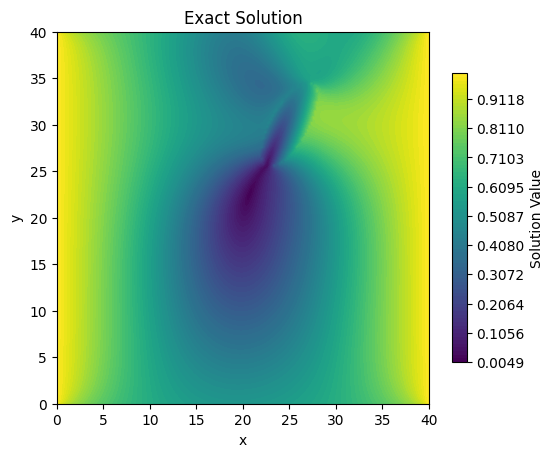

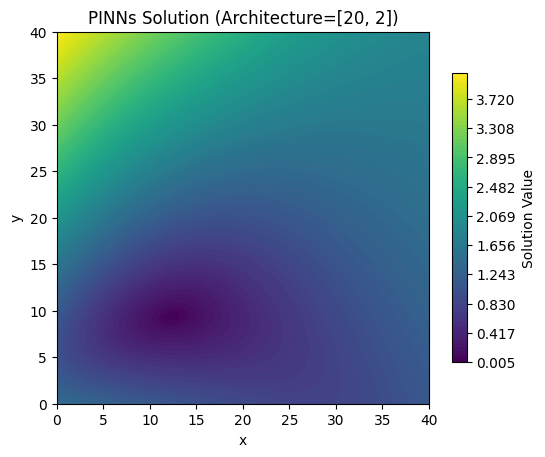

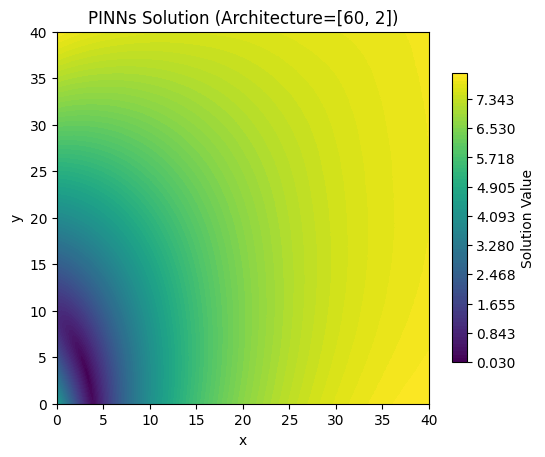

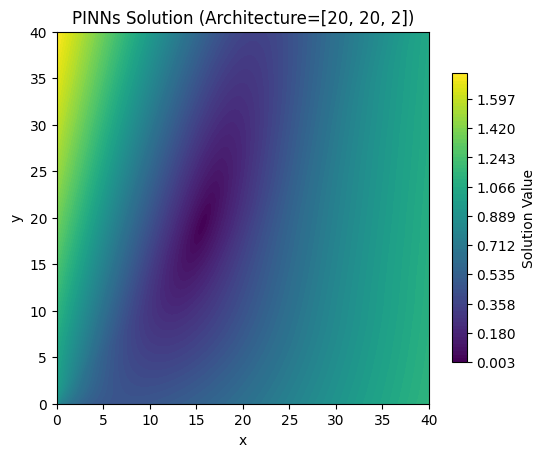

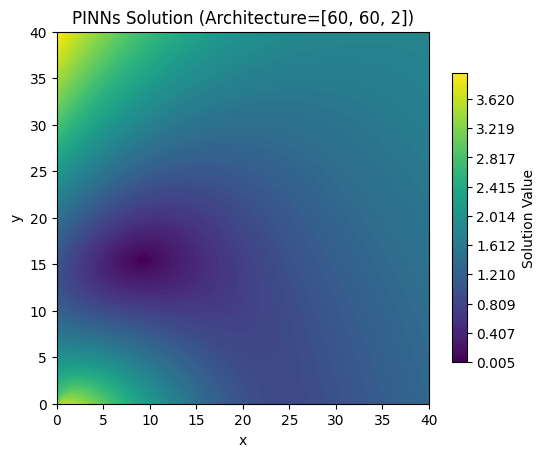

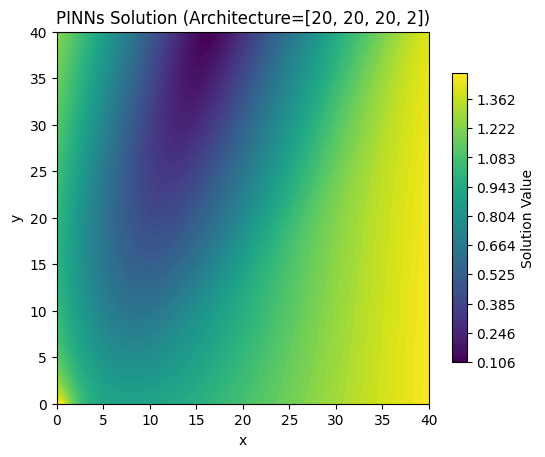

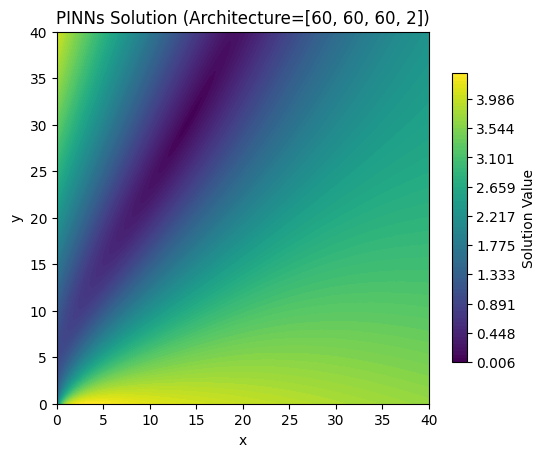

In [ ]:
# Create evaluation points
x_points = np.linspace(0, 40, 200 + 1)
y_points = np.linspace(0, 40, 200 + 1)
X, Y = np.meshgrid(x_points, y_points, indexing='ij')
X, Y = X.flatten(), Y.flatten()
eval_points = np.array([X, Y]).T

with open('PINNs_results.json', 'r') as f:
    data_results = json.load(f)

with open('PINNs_evaluation.json', 'r') as f:
    data_eval = json.load(f)

# Slice results data
domain_pts = data_results['domain_pts']
y_results = data_results['y_results']
y_gt = data_results['y_gt']

arch = data_eval['arch']
times_adam = data_eval['times_adam']
times_lbfgs = data_eval['times_lbfgs']
times_total = data_eval['times_total']
times_eval = data_eval['times_eval']
l2_rel = data_eval['l2_rel']
var = data_eval['var']

# Exact solution
u_exact = np.array(y_gt) # (n,)
u_exact_magnitude = np.sqrt(u_exact[:, 0]**2 + u_exact[:, 1]**2)

# Contour plot settings
# For a consistent scale across all time steps
u_min = u_exact_magnitude.min()
u_max = u_exact_magnitude.max()
# Create n levels between u_min & u_max:
num_levels = 80
levels = np.linspace(u_min, u_max, num_levels)

# Exact solution
fig1 = plt.figure(1, figsize=(6, 5))
ax1 = fig1.add_subplot(1, 1, 1)
sc1 = ax1.tricontourf(X, Y, u_exact_magnitude,
                      levels=levels, cmap='viridis')
ax1.set_title('Exact Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal', adjustable='box')
fig1.colorbar(sc1, ax=ax1, shrink=0.75, label='Solution Value')

# Approximate solution
for idx, architecture in arch.items():
    # Get the approximate solution for this architecture
    u_approx = np.array(y_results[idx])  # (n,)
    u_approx_magnitude = np.sqrt(u_approx[:, 0]**2 + u_approx[:, 1]**2)

    # Contour plot settings
    # For a consistent scale across all time steps
    u_min = u_approx_magnitude.min()
    u_max = u_approx_magnitude.max()
    # Create n levels between u_min & u_max:
    num_levels = 80
    levels = np.linspace(u_min, u_max, num_levels)

    # Contour plot
    fig2 = plt.figure(2, figsize=(6, 5))
    ax2 = fig2.add_subplot(1, 1, 1)
    sc2 = ax2.tricontourf(X, Y, u_approx_magnitude,
                          levels=levels, cmap='viridis')
    ax2.set_title(f"PINNs Solution (Architecture={architecture})")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_aspect('equal', adjustable='box')
    fig2.colorbar(sc2, ax=ax2, shrink=0.75, label='Solution Value')

    # Save figures
    fig_dir = f'./fig/arch_{idx}'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir, exist_ok=True)

    filename = os.path.join(fig_dir, f'sol_{idx}.png')
    fig2.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig2)


# Displacement Configuration

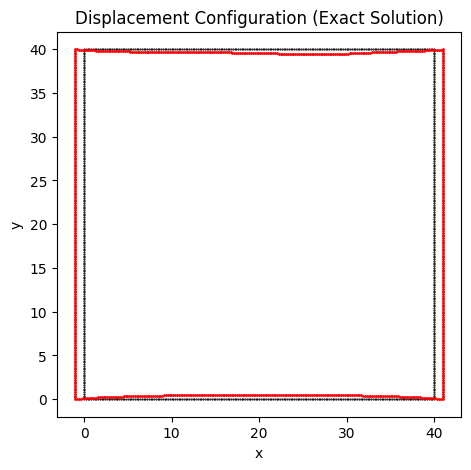

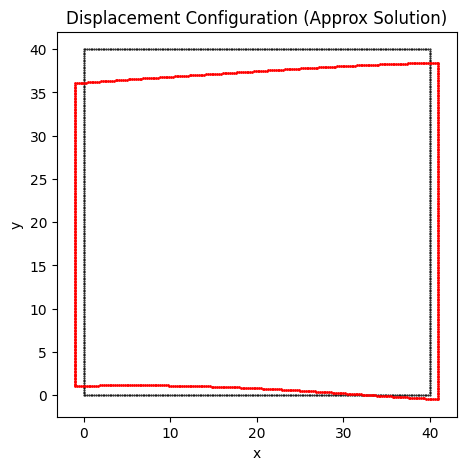

In [ ]:
# Find the boundary indices
eval_points = onp.array(eval_points)
boundary_idx = onp.where((eval_points[:, 0] == 0) | (eval_points[:, 0] == 40) | (eval_points[:, 1] == 0) | (eval_points[:, 1] == 40))

# Arrange approximate displacements
u_approx_converted = onp.array(y_results['0'])

# Exact solution
fig_3 = plt.figure(3, figsize=(6, 5))
ax_3 = fig_3.add_subplot(1, 1, 1)
ax_3.plot(eval_points[boundary_idx, 0], eval_points[boundary_idx, 1], 'k.', markersize=1, label='Boundary')
ax_3.plot(eval_points[boundary_idx, 0] + u_exact[boundary_idx, 0], eval_points[boundary_idx, 1] + u_exact[boundary_idx, 1], 'r.', markersize=2, label='Reference')
ax_3.set_title('Displacement Configuration (Exact Solution)')
ax_3.set_xlabel('x')
ax_3.set_ylabel('y')
ax_3.set_aspect('equal', adjustable='box')
# fig_3.savefig('./fig/ref_config.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_3)

# Approx solution
fig_4 = plt.figure(4, figsize=(6, 5))
ax_4 = fig_4.add_subplot(1, 1, 1)
ax_4.plot(eval_points[boundary_idx, 0], eval_points[boundary_idx, 1], 'k.', markersize=1, label='Boundary')
ax_4.plot(eval_points[boundary_idx, 0] + u_approx_converted[boundary_idx, 0], eval_points[boundary_idx, 1] + u_approx_converted[boundary_idx, 1], 'r.', markersize=2, label='Reference')
ax_4.set_title('Displacement Configuration (Approx Solution)')
ax_4.set_xlabel('x')
ax_4.set_ylabel('y')
ax_4.set_aspect('equal', adjustable='box')
# fig_3.savefig('./fig/ref_config.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_4)
